In [1]:
import pandas as pd
import math
import numpy as np
from sklearn.metrics import classification_report
import torch.nn.functional as F
import torch
import os
from tqdm import tqdm,trange
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer)
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('../data/classification_dataset.csv')

In [44]:
df

,text,l1,l2,l3
0,"Ronald \""Ron\"" D. Boire is an American busines...",Agent,Person,BusinessPerson
1,Astra 1KR is one of the Astra geostationary sa...,Place,Satellite,ArtificialSatellite
2,Cycleryon is an extinct genus of decapod crust...,Species,Animal,Crustacean
3,"Angela Maria of the Heart of Jesus, also calle...",Agent,Cleric,Saint
4,"William Garnet \""Bing\"" Coughlin – Canadian Wo...",Agent,Artist,ComicsCreator
...,...,...,...,...
342776,The Messenger is a quarterly magazine publishe...,Work,PeriodicalLiterature,Magazine
342777,"Seren \""Haf\"" Gibson (born in Ruthin, Denbighs...",Agent,Actor,AdultActor
342778,Anne Margrethe Strømsheim (née Bang) (1914 – 6...,Agent,Person,MilitaryPerson
342779,116 Sirona is a somewhat large and bright-colo...,Place,CelestialBody,Planet


In [24]:
df.l1.value_counts()

Agent             177341
Place              65128
Species            31149
Work               29832
Event              27059
SportsSeason        8307
UnitOfWork          2497
TopicalConcept      1115
Device               353
Name: l1, dtype: int64

<AxesSubplot:>

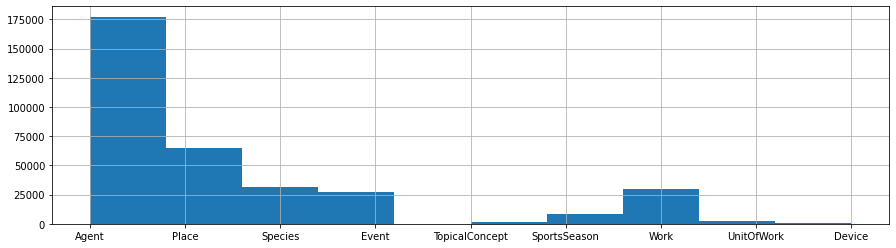

In [8]:
df.l1.hist(figsize=(15,4))

<AxesSubplot:>

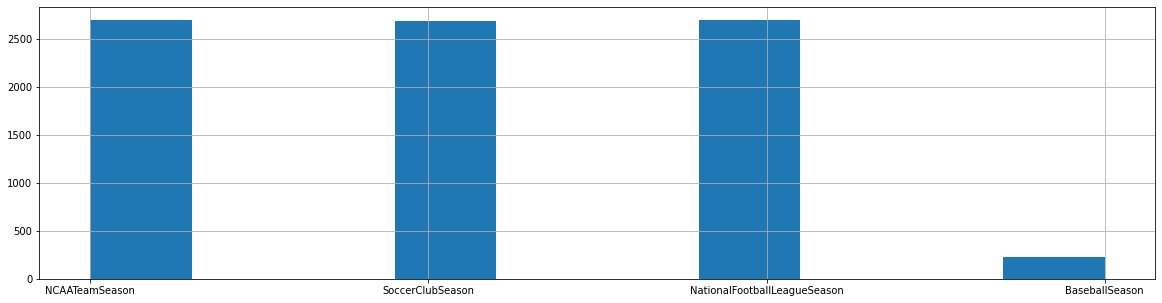

In [43]:
df[df['l1'] == 'SportsSeason'].l3.hist(figsize=(20,5))

In [42]:
df[df['l1'] == 'AutomobileEngine'].l3.value_counts()

Series([], Name: l3, dtype: int64)

<AxesSubplot:>

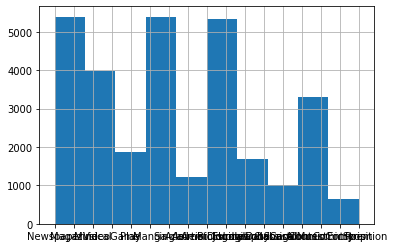

In [23]:
df[df['l1'] == 'Work'].l3.hist()